# Analysis of apartments rent in Dubai, UAE
 For **DIFC** and **Downtown** area

## Preparations

All data was scraped from Bayut website on August 9 and saved as .CSV file.  
First downloading .CSV file from Google Drive with command `! gdown`

In [1]:
! gdown 1EMlXkq1MI4HqYwbcvTl93bKZ2BvRqDCy

Downloading...
From: https://drive.google.com/uc?id=1EMlXkq1MI4HqYwbcvTl93bKZ2BvRqDCy
To: /content/bayut-dubai-difc-downtown.csv
100% 8.85M/8.85M [00:00<00:00, 56.1MB/s]


In [2]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing all necessary libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import time
# from datetime import datetime
# from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor

import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
sns.set_style('darkgrid')

Loading .CSV file with pandas using python engine and checking first 5 rows of data

In [6]:
data = pd.read_csv('bayut-dubai-difc-downtown.csv', engine='python')

In [7]:
pd.set_option("display.max_columns", None)

In [8]:
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

In [9]:
data.head(5)

,web-scraper-order,web-scraper-start-url,pagination,apartmet-link,apartmet-link-href,building,price,rent-frequency,address,beds,baths,area-sqft,description-title,description,reference-no,date-added,balcony-size-sqft,parking,building-info-name,building-info-floors,building-info-year,building-info-area-sqft,furnishing,features-amenities
0,1660037380-2176,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5975062...,NaN,"190,000",Yearly,"The Address The Blvd, Downtown Dubai, Dubai",1 Bed,2 Baths,905 sqft,1 BR Luxury Unit | Serviced | Fully Furnished,Betterhomes are proud to present this stunning...,Bayut - BHM-R-556121,23 May 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Centrally Air-Conditioned
1,1660040273-2805,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5937929...,NaN,"165,000",Yearly,"Downtown Views, Downtown Dubai, Dubai",2 Beds,3 Baths,"1,250 sqft",All Inclusive 15K Monthly | High Floor | Full...,We are delighted to present this fully furnish...,Bayut - MK-R-5701-07-P,10 May 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Parking Spaces: 1
2,1660036840-2061,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5577993...,NaN,"290,000",Yearly,"BLVD Heights Tower 2, BLVD Heights, Downtown D...",2 Beds,3 Baths,"1,759 sqft",AVAILABLE NOW | DUPLEX UNIT | HIGH FLOOR,Housess Global Real Estate is pleased to offer...,Bayut - 879-Ap-R-1951,4 July 2022,NaN,NaN,NaN,NaN,NaN,NaN,Unfurnished,Swimming Pool
3,1660042132-3219,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5942993...,NaN,"185,000",Yearly,"The Address The Blvd, Downtown Dubai, Dubai",1 Bed,2 Baths,905 sqft,DIFC View | Vacant | Fully Furnished | 1 BR,"Features:\n- 1 bed,\n- 24/7 Security,\n- Pool,...",Bayut - BHM-R-555721,12 May 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Centrally Air-Conditioned
4,1660045614-3922,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-6196723...,NaN,"130,000",Yearly,"Downtown Views, Downtown Dubai, Dubai",1 Bed,2 Baths,861 sqft,Available Now | Fully Furnished | Brand New,Brought to you by McCone Properties Properties...,Bayut - MCC-R-5685,3 August 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,NaN


There's a few columns that is not valuable for future analysis such as links, IDs, rent frequency as its only contains annual rent options.  
Let's drop those columns.

In [10]:
data.drop(['apartmet-link-href','rent-frequency','web-scraper-order','web-scraper-start-url','pagination','apartmet-link', 'building'], axis=1, inplace=True)

In [11]:
data.columns

Index(['price', 'address', 'beds', 'baths', 'area-sqft', 'description-title',
       'description', 'reference-no', 'date-added', 'balcony-size-sqft',
       'parking', 'building-info-name', 'building-info-floors',
       'building-info-year', 'building-info-area-sqft', 'furnishing',
       'features-amenities'],
      dtype='object')

First view on data info if there are anything odd or interesting insights

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    4824 non-null   object 
 1   address                  4824 non-null   object 
 2   beds                     4824 non-null   object 
 3   baths                    4802 non-null   object 
 4   area-sqft                4824 non-null   object 
 5   description-title        4824 non-null   object 
 6   description              4824 non-null   object 
 7   reference-no             4824 non-null   object 
 8   date-added               4824 non-null   object 
 9   balcony-size-sqft        1069 non-null   object 
 10  parking                  1188 non-null   object 
 11  building-info-name       1184 non-null   object 
 12  building-info-floors     1184 non-null   float64
 13  building-info-year       1184 non-null   float64
 14  building-info-area-sqft 

Price is an object, that should be changed as number of beds, baths and some othere data.  
Some data are missing, we will deal with that later

In [13]:
data.sample(5)

,price,address,beds,baths,area-sqft,description-title,description,reference-no,date-added,balcony-size-sqft,parking,building-info-name,building-info-floors,building-info-year,building-info-area-sqft,furnishing,features-amenities
286,"350,000","The Address Fountain Views 3, The Address Resi...",2 Beds,3 Baths,"1,602 sqft",Luxurious 2 BR Burj Khalifa View | Prime Location,Key Living Real Estate is delighted to offer y...,Bayut - Keyliving-3309241,7 July 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Furnished
452,"190,000","Opera Grand, Downtown Dubai, Dubai",2 Beds,3 Baths,"1,716 sqft",High floor | Massive unit | Brand new,Azur Properties presents to you this fantastic...,Bayut - AZR-R-2745,4 July 2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Swimming Pool
979,"310,000","The Address Fountain Views 1, The Address Resi...",2 Beds,3 Baths,"1,335 sqft",Best Layout | Furnished | Stunning Views,"Brought to you by Driven Properties, this 2 Be...",Bayut - DP-R-42758,1 November 2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Balcony or Terrace
1692,"105,000","Central Park Residence Tower, Central Park Tow...",1 Bed,2 Baths,"1,123 sqft",Spacious One Bedroom Unit in Central Park Towe...,The Residential Towers offers tastefully desig...,Bayut - 232-Ap-R-3696,6 August 2022,NaN,NaN,NaN,NaN,NaN,NaN,Unfurnished,Parking Spaces: 1
2002,"280,000","Vida Residence Downtown, Downtown Dubai, Dubai",2 Beds,2 Baths,"1,640 sqft",Burj Khalifa View|Fully Furnished|Ready to Move,Silver Oak Properties is proud to present this...,Bayut - 2212-Ap-R-0153,23 March 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Furnished


## Data Preprocessing

### Price column

For column with price converting it to data type int, but first removing comma.

In [14]:
data['price'] = data['price'].str.replace(',','').astype(float).astype(int)
data['price'].sample(5)

2009    119999
1291    300000
1386    230000
1142     40000
3845    114999
Name: price, dtype: int64

### Bedrooms column

For column with number of bedrooms, let's see how many unique values are there and then replace it with a number, if that is a studio then replace it with 0.

In [15]:
data['beds'].unique()

array(['1 Bed', '2 Beds', 'Studio', '3 Beds', '4 Beds', '5 Beds'],
      dtype=object)

In [16]:
data['beds'] = data['beds'].replace(
    {'Studio': 0,
     '1 Bed': 1,
     '2 Beds': 2,
     '3 Beds': 3,
     '4 Beds': 4,
     '5 Beds': 5,
    }
  )


### Bathrooms column

Similar to bedrooms column first checking unique values and then will replace it with numbers to have it as an int data type. Also there are 22 missing values.

In [17]:
data['baths'].unique()

array(['2 Baths', '3 Baths', '1 Bath', '5 Baths', '4 Baths', nan,
       '6 Baths'], dtype=object)

In [18]:
len(data[data['baths'].isnull()])

22

As we can see there's many apartments with huge area and a few bedrooms, at least it should have 1 bathrom.  
However, if we will fill mising values with 1 it might confuse our next analysis.  As it is only 22 missings we can just drop it. 
But, maybe later will comback to this and try to extract info from other columns such as description column.

On the next step will drop missing values, replace strings to numbers and check unique values.

In [19]:
data.dropna(subset=['baths'], inplace=True)

In [20]:
data['baths'] = data['baths'].replace(
    {'1 Bath': 1,
     '2 Baths': 2,
     '3 Baths': 3,
     '4 Baths': 4,
     '5 Baths': 5,
     '6 Baths': 6,
    }
  ).astype(int)

In [21]:
data['baths'].unique()

array([2, 3, 1, 5, 4, 6])

### Area (sqft) column

Replace commas and sqft then convert to int data type. Check first 5 rows.

In [22]:
data['area-sqft'] = (
    data['area-sqft']
    .str.replace('sqft','')
    .str.replace(',','')
    .astype(float)
    .astype(int)
    )
data['area-sqft'].head(5)

0     905
1    1250
2    1759
3     905
4     861
Name: area-sqft, dtype: int64

### Date column

Converting column with date to datetime format

In [23]:
data['date-added'] = pd.to_datetime(data['date-added'], format = "%d %B %Y")

### Furnishing column

In [24]:
data['furnishing'].unique()

array(['Furnished', 'Unfurnished', nan], dtype=object)

Replacing **NaN** with **-1** value, **Furnished** as **1** and **Unfurnished** as **0**

In [25]:
data['furnishing'] = data['furnishing'].fillna(-1)

In [26]:
data['furnishing'] = data['furnishing'].replace(
    {'Furnished': 1,
     'Unfurnished': 0,
    }
  ).astype(int)

In [27]:
data['furnishing'].unique()

array([ 1,  0, -1])

### Balcony (sqft) column

Replacing missing values with string **'-1'**, then with the rest dropping sqft and converting to int data type.

In [28]:
data['balcony-size-sqft'] = data['balcony-size-sqft'].fillna('-1')

In [29]:
data['balcony-size-sqft'] = (
    data['balcony-size-sqft']
    .str.replace('sqft','')
    .str.replace(',','')
    .astype(float)
    .astype(int)
    )

### Parking

Some listings are missing parking information, will replace it with 0. However, such information might be in description or other text columns. 

In [30]:
data['parking'] = data['parking'].fillna('No')

In [31]:
data['parking'] = data['parking'].replace(
    {'Yes': 1,
     'No': 0,
    }
  ).astype(int)

### Building info name

That column will be processed later with feature engeneering.

### Building info floors

Number of floors, some buildings are missing that information and temporary will replace it with **0** 

In [32]:
data['building-info-floors'].unique()

array([nan, 73., 19., 55., 23., 56.,  9., 40., 30., 31., 41.,  4., 51.,
       20., 33., 65., 17., 21., 62., 16., 43., 18., 45.,  5., 34., 39.,
       25.,  8., 48., 36., 32., 28., 64., 27., 60., 52., 47., 24., 26.,
        6.,  7., 12., 42.])

In [33]:
data['building-info-floors'] = data['building-info-floors'].fillna(0)

In [34]:
data['building-info-floors'] = data['building-info-floors'].astype(int)

### Building info year

Will do the same for building completion year. Temporary replace missing values with **0** and change data type.

In [35]:
data['building-info-year'].unique()

array([  nan, 2021., 2012., 2019., 2017., 2008., 2013., 2010., 2020.,
       2009., 2018., 2022., 2016., 2015.])

In [36]:
data['building-info-year'] = data['building-info-year'].fillna(0)

In [37]:
data['building-info-year'] = data['building-info-year'].astype(int)

### Building info area (sqft)

For a few reasons will drop this column. First it is not so easy to find such information and get that data on each building, second reason is that unlikely total area of a buklding will affect rent prices more that number of floors or location.

In [38]:
data.drop(['building-info-area-sqft'], axis=1, inplace=True)

### Features and amenities

Missing values will replace with **Unknown**

In [39]:
data['features-amenities'] = data['features-amenities'].fillna('Unknown')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4823
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   price                 4802 non-null   int64         
 1   address               4802 non-null   object        
 2   beds                  4802 non-null   int64         
 3   baths                 4802 non-null   int64         
 4   area-sqft             4802 non-null   int64         
 5   description-title     4802 non-null   object        
 6   description           4802 non-null   object        
 7   reference-no          4802 non-null   object        
 8   date-added            4802 non-null   datetime64[ns]
 9   balcony-size-sqft     4802 non-null   int64         
 10  parking               4802 non-null   int64         
 11  building-info-name    1184 non-null   object        
 12  building-info-floors  4802 non-null   int64         
 13  building-info-year

Rename all columns to avoid confusion

In [41]:
data.rename(columns={'area-sqft': 'area_sqft',
                     'description-title': 'description_title',
                     'reference-no': 'reference_no',
                     'date-added': 'date_added',
                     'balcony-size-sqft': 'balcony_size_sqft',
                     'building-info-name': 'building_info_name',
                     'building-info-floors': 'building_info_floors',
                     'building-info-year': 'building_info_year',
                     'features-amenities': 'features_amenities',
                     }, inplace=True)

## Exploratory Data Analysis (EDA)

Defining some functions for future use in analysis

In [68]:
def whiskers_limits(series):
  """Print Min, Max values for whiskers"""

  q1 = np.percentile(series, 25)  # Q1
  q2 = np.percentile(series, 50)  # Q2 (Median)
  q3 = np.percentile(series, 75)  # Q3
  whisker_maximum = round(q3 + ((q3 - q1) * 1.5), 2) # “maximum”: Q3 + 1.5 * IQR 
  whisker_minimum = round(q1 - ((q3 - q1) / 1.5), 2) # “minimum”: Q1 - 1.5 * IQR
  above_whisker_maximum = data.query('@series > @whisker_maximum')[series.name].count()
  total_amount = data[series.name].count()
  
  print(f"{whisker_minimum} - Minimum value for left 'whisker'\n"
        f"{whisker_maximum} - Max value for right 'whisker',\n"
        f"{above_whisker_maximum} (or {round(above_whisker_maximum / total_amount * 100, 2)}%)"
        f" of {total_amount} - N elements after the right 'whisker'")

In [69]:
def count_text2feature(df, keyword):
  """Count how many objects in a df contains a keyword"""
  
  count = df[(df['description'].str.lower()
      .str.contains(keyword, case = False, regex = True) == True) | 
      (df['description_title'].str.lower()
      .str.contains(keyword, case = False, regex = True) == True) | 
      (df['features_amenities'].str.lower()
      .str.contains(keyword, case = False, regex = True) == True)]['price'].count()
  return print(f"Found {count} objects with that keyword")

In [70]:
def text2feature(new_column, keyword):
    """From text columns (description_title, description, features_amenities) 
    find matchings with keyword and set values 1 - True and 0 - False"""
    
    data[new_column] = np.where(
        (data['description'].str.lower()
        .str.contains(keyword, case = False, regex = True) == True) | 
        (data['description_title'].str.lower()
        .str.contains(keyword, case = False, regex = True) == True) | 
        (data['features_amenities'].str.lower()
        .str.contains(keyword, case = False, regex = True) == True),
        1, 0)

### Adding new features

#### Address column

For column with address, it has name of the city, area, bulding name or even a complex of buildings name.  
We need it to be separated to diferent columns for future analysis. We can see that a bulding name is always goes first, city is always the last and before city is area name.  
So, let's split the address and save each element to a new column.

In [45]:
data['address_city'] = data['address'].str.split(', ').str[-1]
data['address_area'] = data['address'].str.split(', ').str[-2]
data['address_building'] = data['address'].str.split(', ').str[0]

In [46]:
data[['address', 'address_city', 'address_area', 'address_building']].sample(5)

,address,address_city,address_area,address_building
2576,"Downtown Views, Downtown Dubai, Dubai",Dubai,Downtown Dubai,Downtown Views
3494,"Downtown Views, Downtown Dubai, Dubai",Dubai,Downtown Dubai,Downtown Views
2381,"The Address Fountain Views 3, The Address Resi...",Dubai,Downtown Dubai,The Address Fountain Views 3
1742,"The Address Dubai Mall, Downtown Dubai, Dubai",Dubai,Downtown Dubai,The Address Dubai Mall
1124,"48 Burj Gate, Downtown Dubai, Dubai",Dubai,Downtown Dubai,48 Burj Gate


We no longer needed column with address, let's drop it.

In [47]:
data.drop(['address'], axis=1, inplace=True)

As earlier building name was extracted from full address column and saved in new, this one could be dropped. Before that, let's check if names actualy match.

In [48]:
data[['building_info_name', 'address_building']].sample(10)

,building_info_name,address_building
3349,NaN,The Address Sky View Tower 2
2985,Burj Views Tower C,Burj Views C
2521,NaN,Boulevard Point
3423,NaN,Roda Al Murooj
3565,Address Fountain Views Residences - Tower 2,The Address Fountain Views 2
3509,Address Fountain Views Residences - Tower 1,The Address Fountain Views 1
1385,NaN,Burj Views C
3694,NaN,The Residence 5
494,NaN,Burj Khalifa
514,NaN,The Lofts East


In [49]:
data.drop(['building_info_name'], axis=1, inplace=True)

In [50]:
data.head()

,price,beds,baths,area_sqft,description_title,description,reference_no,date_added,balcony_size_sqft,parking,building_info_floors,building_info_year,furnishing,features_amenities,address_city,address_area,address_building
0,190000,1,2,905,1 BR Luxury Unit | Serviced | Fully Furnished,Betterhomes are proud to present this stunning...,Bayut - BHM-R-556121,2022-05-23,-1,0,0,0,1,Centrally Air-Conditioned,Dubai,Downtown Dubai,The Address The Blvd
1,165000,2,3,1250,All Inclusive 15K Monthly | High Floor | Full...,We are delighted to present this fully furnish...,Bayut - MK-R-5701-07-P,2022-05-10,-1,0,0,0,1,Parking Spaces: 1,Dubai,Downtown Dubai,Downtown Views
2,290000,2,3,1759,AVAILABLE NOW | DUPLEX UNIT | HIGH FLOOR,Housess Global Real Estate is pleased to offer...,Bayut - 879-Ap-R-1951,2022-07-04,-1,0,0,0,0,Swimming Pool,Dubai,Downtown Dubai,BLVD Heights Tower 2
3,185000,1,2,905,DIFC View | Vacant | Fully Furnished | 1 BR,"Features:\n- 1 bed,\n- 24/7 Security,\n- Pool,...",Bayut - BHM-R-555721,2022-05-12,-1,0,0,0,1,Centrally Air-Conditioned,Dubai,Downtown Dubai,The Address The Blvd
4,130000,1,2,861,Available Now | Fully Furnished | Brand New,Brought to you by McCone Properties Properties...,Bayut - MCC-R-5685,2022-08-03,-1,0,0,0,1,Unknown,Dubai,Downtown Dubai,Downtown Views


#### Spliting date 

Adding four new columns with year, month, day and weekday

In [51]:
data['year'] = pd.DatetimeIndex(data['date_added']).year 
data['month'] = pd.DatetimeIndex(data['date_added']).month 
data['day'] = pd.DatetimeIndex(data['date_added']).day
data['weekday'] = pd.DatetimeIndex(data['date_added']).weekday

In [52]:
data[['date_added', 'year', 'day', 'month', 'weekday']].head(5)

,date_added,year,day,month,weekday
0,2022-05-23,2022,23,5,0
1,2022-05-10,2022,10,5,1
2,2022-07-04,2022,4,7,0
3,2022-05-12,2022,12,5,3
4,2022-08-03,2022,3,8,2


#### Price per square foot

In [53]:
data['price_sqft'] = data['price'] / data['area_sqft']

In [54]:
data['price_sqft'] = pd.to_numeric(round(data['price_sqft']), downcast = 'integer')

In [55]:
# data['price_category'] = pd.cut(data.price, bins = 20)

In [56]:
# data[['price', 'price_category']].sample(10)

#### Chiller

Counting how many objects contains that keyword

In [71]:
count_text2feature(data, 'chiller')

Found 902 objects with that keyword


Creating new column and saving

In [61]:
text2feature('chiller', 'chiller')

Checking if new data was saved

In [62]:
data['chiller'].sum()

902

Returns the relative frequency by dividing all values by the sum of values

In [63]:
data['chiller'].value_counts(normalize=True)

0   0.81
1   0.19
Name: chiller, dtype: float64

#### Parking

In [72]:
count_text2feature(data, 'parking')

Found 3579 objects with that keyword


In [73]:
text2feature('parking', 'parking')

In [74]:
data['parking'].sum()

3579

In [75]:
data['parking'].value_counts(normalize=True)

1   0.75
0   0.25
Name: parking, dtype: float64

#### Bills 

In [86]:
count_text2feature(data, 'bills')

Found 817 objects with that keyword


In [87]:
text2feature('bills', 'bills')

In [88]:
data['bills'].sum()

817

In [89]:
data['bills'].value_counts(normalize=True)

0   0.83
1   0.17
Name: bills, dtype: float64

In [90]:
data['bills'].unique()

array([0, 1])

#### Reordering DataFrame columns

In [91]:
data.columns

Index(['price', 'price_sqft', 'beds', 'baths', 'area_sqft',
       'description_title', 'description', 'reference_no', 'date_added',
       'balcony_size_sqft', 'chiller', 'bills', 'parking', 'furnishing',
       'features_amenities', 'building_info_floors', 'building_info_year',
       'address_city', 'address_area', 'address_building', 'year', 'month',
       'day', 'weekday'],
      dtype='object')

In [101]:
data = data.reindex(columns=['price',
                             'price_sqft',
                             'area_sqft',
                             'beds',
                             'baths',
                             'balcony_size_sqft',
                             'chiller',
                             'bills',
                             'parking',
                             'furnishing',
                             'features_amenities',
                             'description_title',
                             'description',
                             'reference_no',
                             'building_info_floors',
                             'building_info_year',
                             'address_city',
                             'address_area',
                             'address_building',
                             'date_added',
                             'year',
                             'month',
                             'day',
                             'weekday'])

### Number of uniques per feature

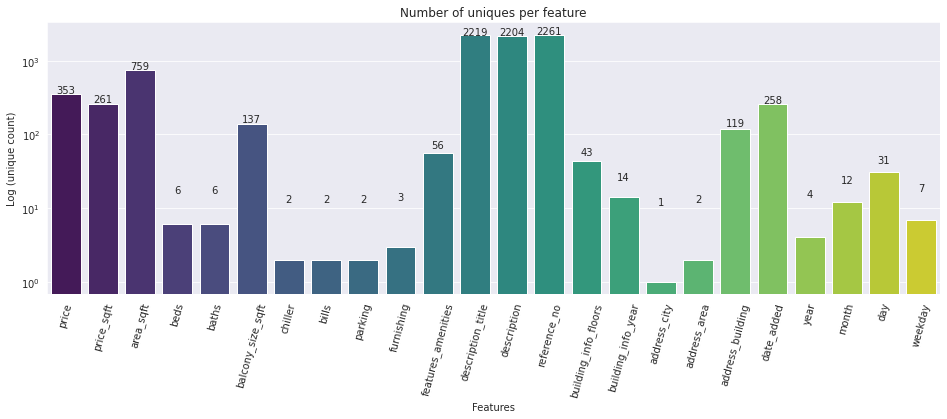

In [104]:
plt.figure(figsize=(16, 5))

cols = data.columns
uniques = [len(data[col].unique()) for col in cols]

ax = sns.barplot(x = cols,
                 y = uniques,
                 palette = 'viridis',
                 log = True,
                 )

ax.set(xlabel = 'Features',
       ylabel = 'Log (unique count)',
       title = 'Number of uniques per feature',
       )

for p, uniq in zip(ax.patches, uniques):
  ax.text(p.get_x() + p.get_width()/2., uniq + 10, uniq, ha = 'center')

ax.set_xticklabels(ax.get_xticklabels(), rotation = 75);

### Price

Prices vary for all listings

In [170]:
bedrooms_palette = {0: '#ffb142',
                    1: '#218c74',
                    2: '#474787',
                    3: '#b33939',
                    4: '#227093',
                    5: '#84817a',
                    }

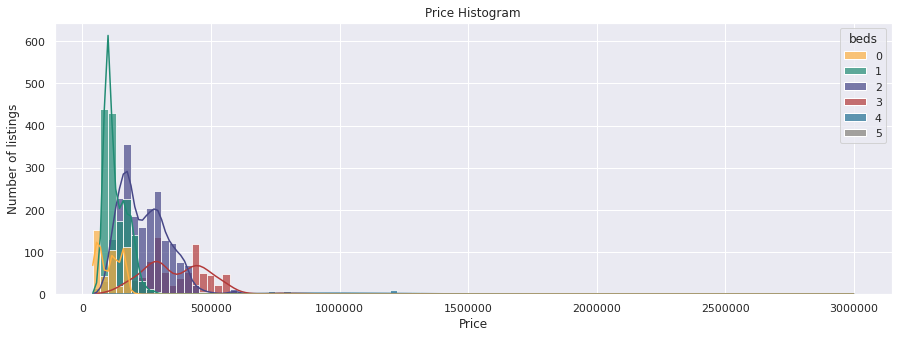

In [190]:
data_prices = data[['beds', 'price']]

sns.set(rc={'figure.figsize':(15, 5)})
sns.histplot(data=data_prices,
             x='price',
             hue = 'beds',
             alpha = .7,
             kde = True,
             bins = 100,
             palette = bedrooms_palette,
)
plt.title('Price Histogram')
plt.ylabel('Number of listings')
plt.xlabel('Price')
plt.ticklabel_format(axis='x', style='plain')
# plt.legend(title='Bedrooms', labels=['Studio','1 BDR','2 BDR','3 BDR','4 BDR','5 BDR'])
plt.show()

We can see outliers messing all data starting from price ~500,000 and up to 3,000,000. Most likely it's a huge apartment with many rooms and more luxurious or simply a mistake in numbers.  
We would need to look into more common range of prices.

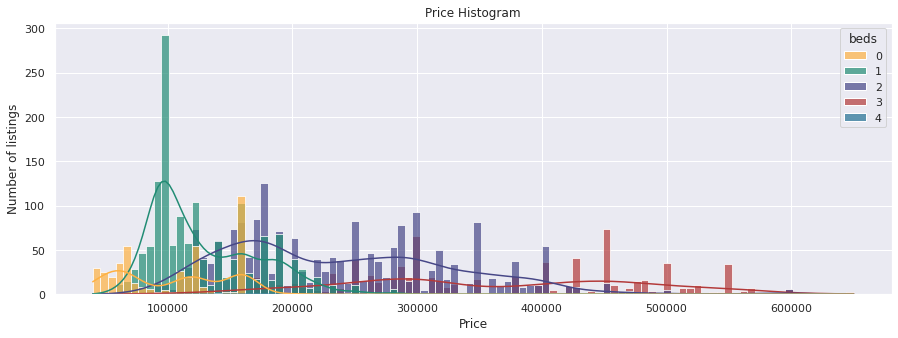

In [189]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.histplot(data = data.query('price < 700_000')[['beds', 'price']],
             x = 'price',
             hue = 'beds',
             alpha = .7,
             kde = True,
             bins = 100,
             palette = bedrooms_palette,
             
)
plt.title('Price Histogram')
plt.ylabel('Number of listings')
plt.xlabel('Price')
plt.ticklabel_format(axis = 'x', style = 'plain')
plt.show()

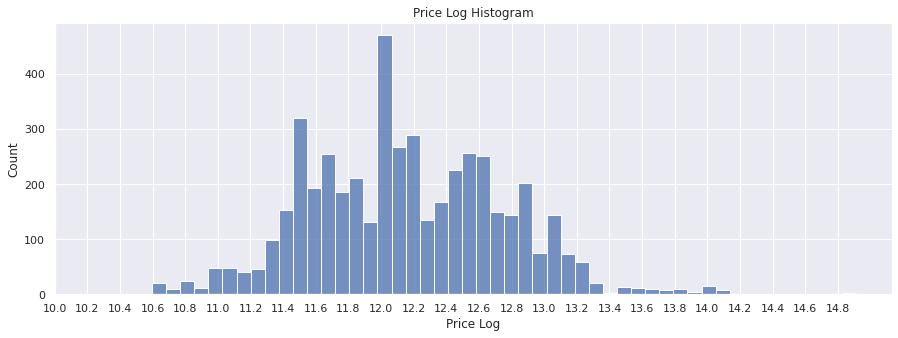

In [141]:
data['price_log'] = np.log(data['price'] + 1)


sns.set(rc={'figure.figsize':(15, 5)})
sns.histplot(data['price_log'].dropna(), bins = 50)
plt.title('Price Log Histogram')
plt.ylabel('Count')
plt.xlabel('Price Log')
plt.xticks(np.arange(10, 15, 0.2))
plt.show()

In [ ]:
np.log(170_000)

12.043553716032399

In [ ]:
np.exp(11.2), np.exp(13.2)

(73130.44183341545, 540364.9372466916)

In [ ]:
data['price'].describe()

count      4802.00
mean     228229.83
std      171535.69
min       40000.00
25%      120000.00
50%      180000.00
75%      295000.00
max     3000000.00
Name: price, dtype: float64

Using method describe it's easy to see that all prices start as minimum 40,000. Enormous difference between third quartile and max value.

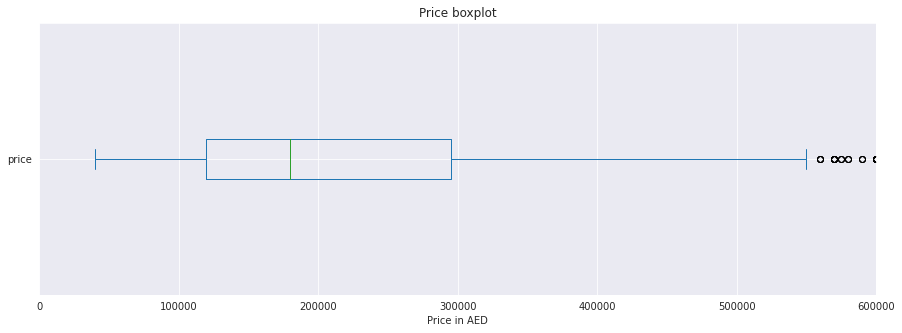

In [ ]:
data['price'].plot(
    kind='box',
    title = "Price boxplot",
    figsize = (15, 5),
    grid = True,
    vert = False,
)
plt.xlim(0, 600_000)
plt.xlabel('Price in AED')
plt.show()

In [142]:
# whiskers_limits(data['price'])

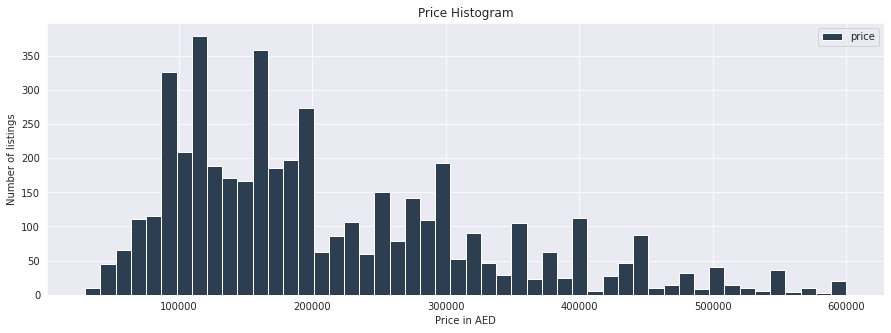

In [ ]:
data['price'].plot(
    kind = 'hist',
    bins = 50,
    range = (30_000, 600_000),
    title = "Price Histogram",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Price in AED')
plt.ticklabel_format(axis='x', style='plain')
# plt.xticks(np.arange(30_000, 600_000, 10_000))
plt.show()

Boxplot to visualise range of prices for all apartments based on number of bedrooms

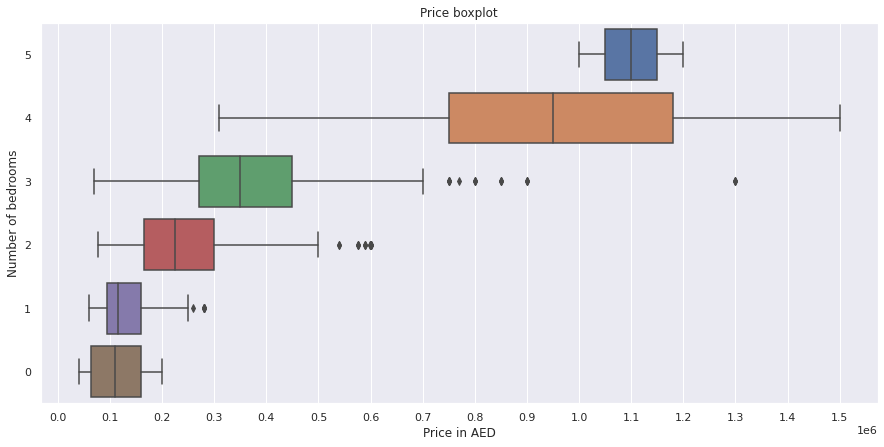

In [ ]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(data = data.query('price < 2_000_000')[['price', 'beds']],
            x = 'price',
            y = 'beds',
            orient = "h",
            order = [5,4,3,2,1,0],
            )
plt.title('Price boxplot')
plt.ylabel('Number of bedrooms')
plt.xlabel('Price in AED')
plt.xticks(np.arange(0, 1_600_000, 100_000))
plt.show()

- Studio and 1 bedroom apartments are almost in the same price range, maybe due to similar total area of an apartment.   
- Difference between 1 and 2 bedrooms are well noticed, but also has some outliers, that could be listings in a new buildings or at exceptional locations. 
- Listings between 3 and 4 bedrooms has huge difference, but even 4 bedrooms  apartments itselves has very wide price range. So wide that even 5 bedrooms apartments could be cheaper.  

**[!]** - Keep in mind though that all prices on this boxplot are for all apartments furnished and unfurnished, in both districts DIFC and Downtown.

### Area 

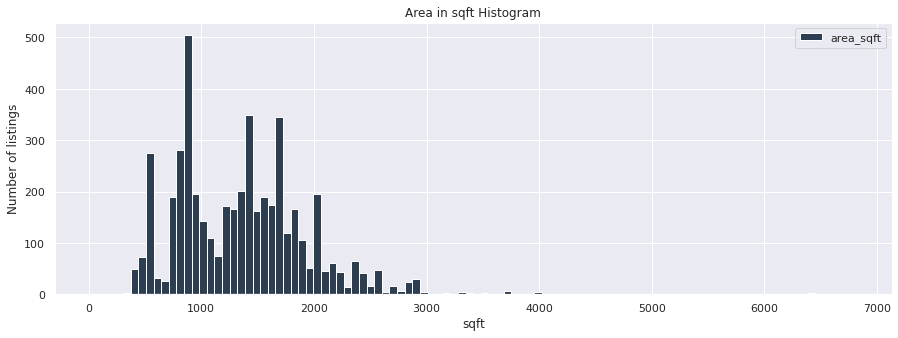

In [ ]:
data['area_sqft'].plot(
    kind = 'hist',
    bins = 100,
    # range = (0, 25_000_000),
    title = "Area in sqft Histogram",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('sqft')
plt.ticklabel_format(axis='x', style='plain')
# plt.xticks(np.arange(0, 600_000, 10_000))
plt.show()

In [ ]:
data['area_sqft'].describe()

count   4802.00
mean    1362.79
std      588.71
min       37.00
25%      882.00
50%     1346.00
75%     1716.00
max     6792.00
Name: area_sqft, dtype: float64

Minimum area size is 37 sqft that couldn't be right even for studio apartment. 

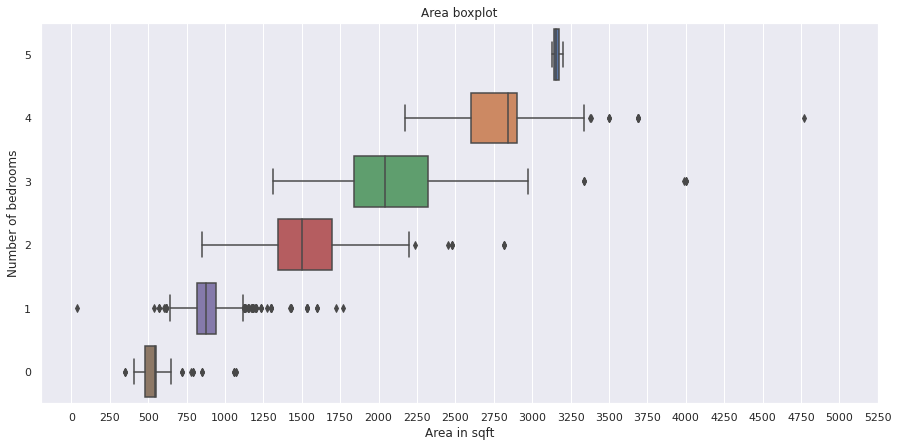

In [ ]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(data = data.query('area_sqft < 5_000')[['area_sqft', 'beds']],
            x = 'area_sqft',
            y = 'beds',
            orient = "h",
            order = [5,4,3,2,1,0],
            )
plt.title('Area boxplot')
plt.ylabel('Number of bedrooms')
plt.xlabel('Area in sqft')
plt.xticks(np.arange(0, 5_500, 250))
plt.show()

### Number of bedrooms

Number of bedrooms across all listings 

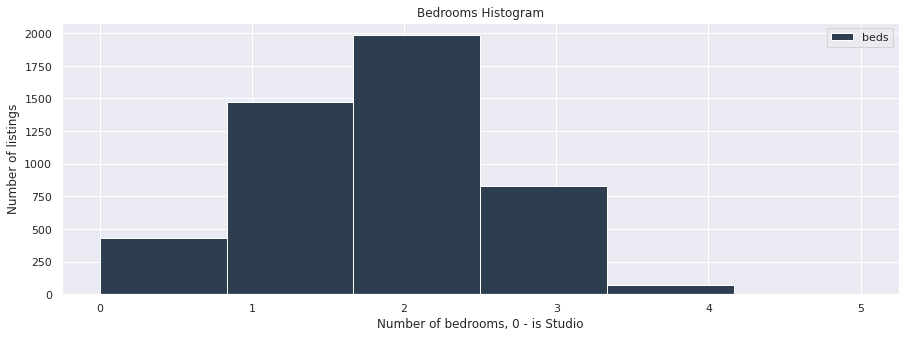

In [ ]:
data['beds'].plot(
    kind = 'hist',
    title = "Bedrooms Histogram",
    bins = 6,
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Number of bedrooms, 0 - is Studio')
plt.ticklabel_format(axis='x', style='plain')
plt.show()

From the diagram above it seams that on the market right now more apartments with two bedrooms, then with one bedroom. Very few with 4 and almost nithing with 5. 
Let's count how many listings of each exacly 

In [ ]:
data['beds'].value_counts()

2    1983
1    1474
3     832
0     435
4      75
5       3
Name: beds, dtype: int64

More listings of two bedroom apartemnts followed by one bedroom

#### One bedroom apartments (1BDR)

In [ ]:
data_1BDR = data.query('beds == 1')

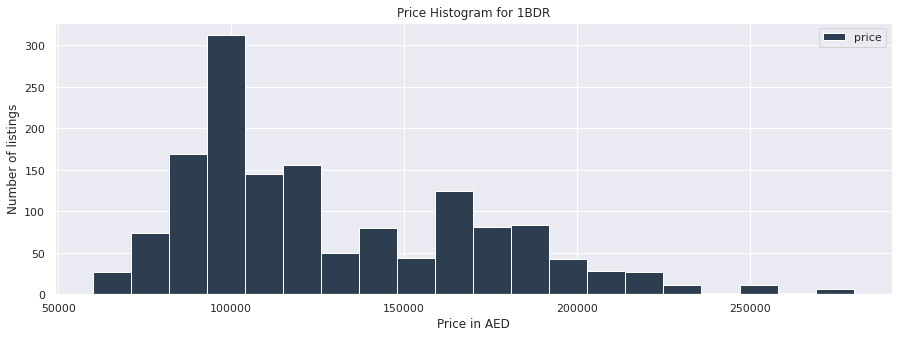

In [ ]:
data_1BDR['price'].plot(
    kind = 'hist',
    bins = 20,
    # range = (30_000, 600_000),
    title = "Price Histogram for 1BDR",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Price in AED')
plt.ticklabel_format(axis='x', style='plain')
plt.show()

In [ ]:
data_1BDR['price'].describe()

count     1474.00
mean    128599.18
std      42612.28
min      59998.00
25%      95000.00
50%     115000.00
75%     160000.00
max     280000.00
Name: price, dtype: float64

In [ ]:
data_1BDR[['price', 'area_sqft', 'baths']].corr()

,price,area_sqft,baths
price,1.00,0.05,0.07
area_sqft,0.05,1.00,0.21
baths,0.07,0.21,1.00


## ML

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4823
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   price                 4802 non-null   int64         
 1   price_sqft            4802 non-null   int16         
 2   beds                  4802 non-null   int64         
 3   baths                 4802 non-null   int64         
 4   area_sqft             4802 non-null   int64         
 5   description_title     4802 non-null   object        
 6   description           4802 non-null   object        
 7   reference_no          4802 non-null   object        
 8   date_added            4802 non-null   datetime64[ns]
 9   balcony_size_sqft     4802 non-null   int64         
 10  parking               4802 non-null   int64         
 11  furnishing            4802 non-null   int64         
 12  features_amenities    4802 non-null   object        
 13  building_info_floo

In [ ]:
# data_ml = data.query('balcony_size_sqft > 0 and building_info_floors > 0 and building_info_year > 0 and furnishing > -1').copy()

In [ ]:
data_ml = data.copy()

In [ ]:
data_ml['address_area'].unique()

array(['Downtown Dubai', 'DIFC'], dtype=object)

In [ ]:
data_ml['address_area'] = data_ml['address_area'].replace(
    {'Downtown Dubai': 1,
     'DIFC': 0,
    }
  ).astype(int)

In [ ]:
data_ml.drop(['balcony_size_sqft',
              'building_info_floors',
              'building_info_year',
              'description_title',
              'description',
              'reference_no',
              'date_added',
              'features_amenities',
              'address_city'],
              axis=1, inplace=True)

In [ ]:
data_ml = data_ml.query('furnishing > -1')

In [ ]:
data_ml['year'].unique()

array([2022, 2021, 2020, 2019])

In [ ]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3287 entries, 0 to 4823
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             3287 non-null   int64 
 1   price_sqft        3287 non-null   int16 
 2   beds              3287 non-null   int64 
 3   baths             3287 non-null   int64 
 4   area_sqft         3287 non-null   int64 
 5   parking           3287 non-null   int64 
 6   furnishing        3287 non-null   int64 
 7   address_area      3287 non-null   int64 
 8   address_building  3287 non-null   object
 9   year              3287 non-null   int64 
 10  month             3287 non-null   int64 
 11  day               3287 non-null   int64 
 12  weekday           3287 non-null   int64 
dtypes: int16(1), int64(11), object(1)
memory usage: 340.3+ KB


In [ ]:
data_ml.head()

,price,price_sqft,beds,baths,area_sqft,parking,furnishing,address_area,address_building,year,month,day,weekday
0,190000,210,1,2,905,0,1,1,The Address The Blvd,2022,5,23,0
1,165000,132,2,3,1250,0,1,1,Downtown Views,2022,5,10,1
2,290000,165,2,3,1759,0,0,1,BLVD Heights Tower 2,2022,7,4,0
3,185000,204,1,2,905,0,1,1,The Address The Blvd,2022,5,12,3
4,130000,151,1,2,861,0,1,1,Downtown Views,2022,8,3,2


### Label Encoding

As several listings could be in the same building, there are a large number of unique duildings. All of them are just names, so we need to encode it before feeding to a model.  
Encoding also could help to see if there are correlations, maybe not so strong but perhaps closer a building to a niceer location could affect the price.

In [ ]:
encoder = LabelEncoder()
data_ml_encoded = data_ml.copy()
encoder.fit(data_ml_encoded['address_building'])
data_ml_encoded['address_building'] = encoder.transform(data_ml_encoded['address_building'])

In [ ]:
# data_ml = pd.get_dummies(data_ml, drop_first=True)
# # display(data_ml.head())

# data_ml.reset_index(drop=True)
# # data_ml.info()

### Correlation

In [ ]:
data_ml_encoded.corr()

,price,price_sqft,beds,baths,area_sqft,parking,furnishing,address_area,address_building,year,month,day,weekday
price,1.00,0.52,0.64,0.63,0.78,0.06,0.21,0.13,0.26,-0.00,-0.10,-0.02,-0.07
price_sqft,0.52,1.00,0.06,0.09,0.10,0.03,0.38,0.22,0.35,-0.16,0.08,0.01,-0.04
beds,0.64,0.06,1.00,0.89,0.89,0.03,-0.08,-0.00,0.14,0.12,-0.19,-0.01,-0.04
baths,0.63,0.09,0.89,1.00,0.85,0.04,-0.08,-0.02,0.13,0.12,-0.16,-0.03,-0.04
area_sqft,0.78,0.10,0.89,0.85,1.00,0.03,-0.05,-0.00,0.12,0.08,-0.17,-0.03,-0.05
parking,0.06,0.03,0.03,0.04,0.03,1.00,0.04,0.13,0.03,0.07,-0.05,0.01,-0.04
furnishing,0.21,0.38,-0.08,-0.08,-0.05,0.04,1.00,0.16,0.34,-0.13,0.05,-0.01,-0.03
address_area,0.13,0.22,-0.00,-0.02,-0.00,0.13,0.16,1.00,0.04,0.04,-0.01,0.03,-0.06
address_building,0.26,0.35,0.14,0.13,0.12,0.03,0.34,0.04,1.00,-0.08,0.00,-0.02,-0.00
year,-0.00,-0.16,0.12,0.12,0.08,0.07,-0.13,0.04,-0.08,1.00,-0.50,-0.02,-0.07


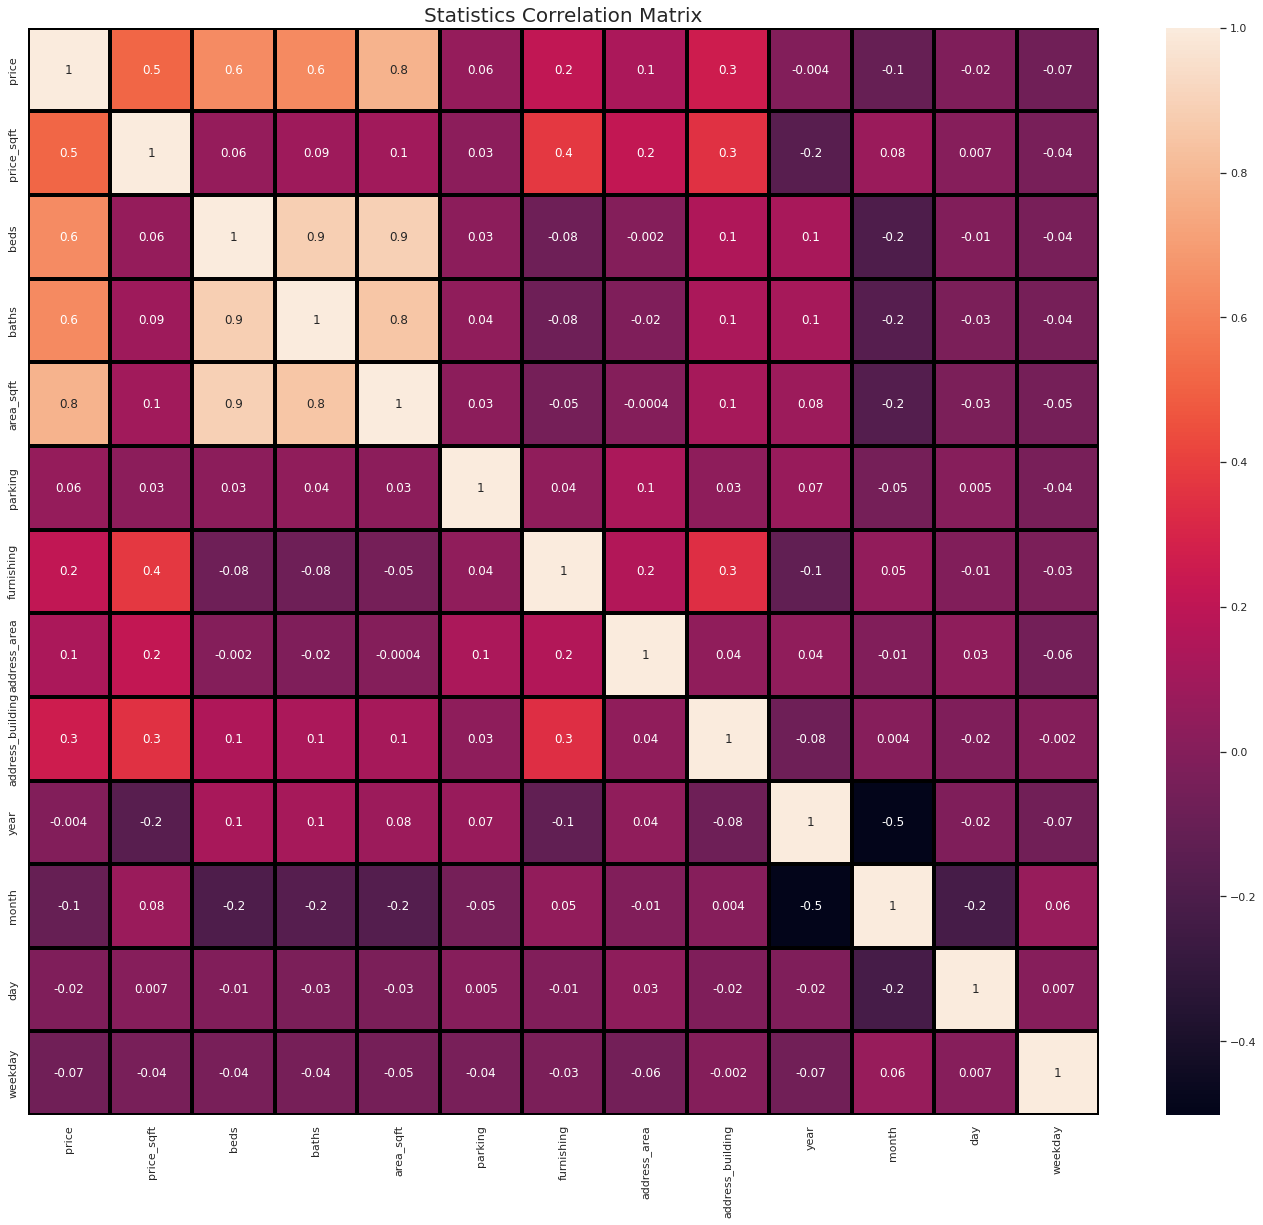

In [ ]:
plt.figure(figsize=(24,20))
sns.heatmap(data_ml_encoded.corr(), annot=True, fmt='.01g', linewidths=3, linecolor='black')
plt.title('Statistics Correlation Matrix', fontsize=20)
plt.show()

This correlation matrix is simply a table showing the correlation coefficients between variables

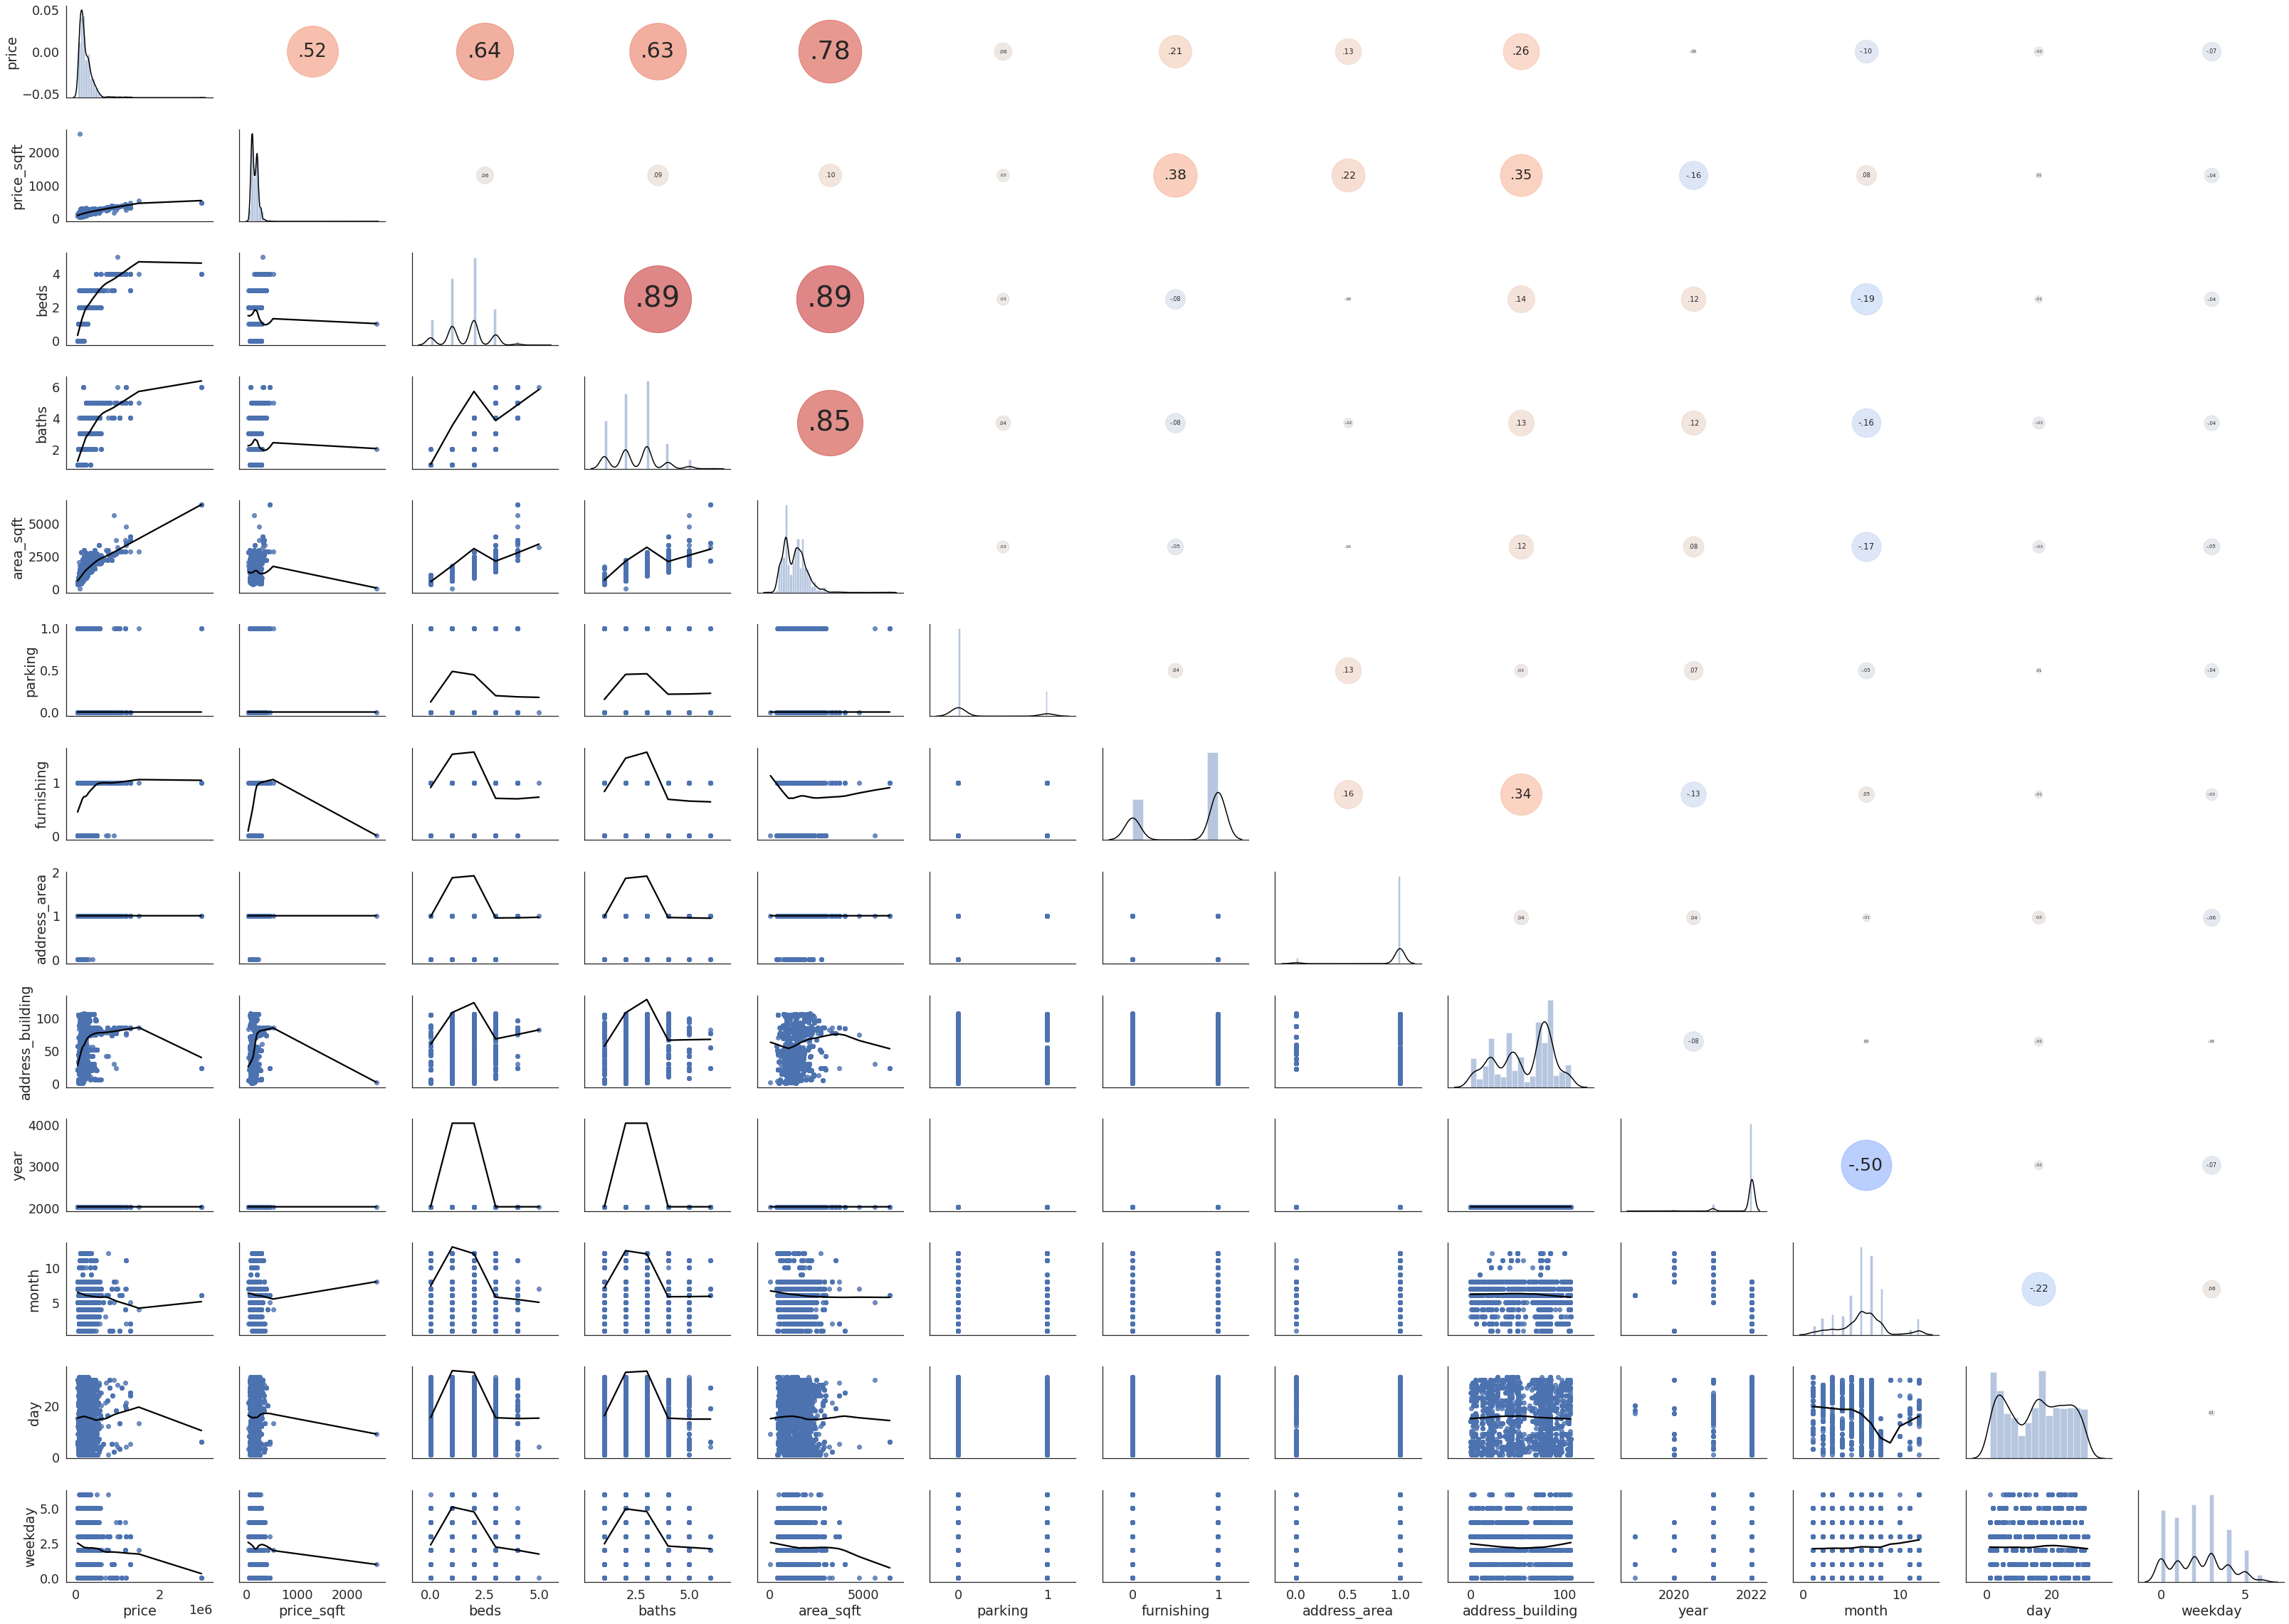

In [ ]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(data_ml_encoded, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

### Split train & test

In [ ]:
data_ml_train, data_ml_valid = train_test_split(data_ml, test_size=0.40, random_state=12345)
data_ml_test, data_ml_valid = train_test_split(data_ml_valid, test_size=0.50, random_state=12345)

In [ ]:
print(data_ml_train.shape)
print(data_ml_valid.shape)
print(data_ml_test.shape)

(1972, 13)
(658, 13)
(657, 13)


In [ ]:
features_train = data_ml_train.drop(['price'], axis=1)
target_train = data_ml_train['price']

features_test = data_ml_test.drop(['price'], axis=1)
target_test = data_ml_test['price']

features_valid = data_ml_valid.drop(['price'], axis=1)
target_valid = data_ml_valid['price']

### Scaling

In [ ]:
# data_ml.head(1)

In [ ]:
# numeric = ['weekday', 'beds', 'baths', 'price_sqft', 'area_sqft', 'address_building','year', 'month', 'day']

# scaler = StandardScaler()
# scaler.fit(features_train[numeric])

# features_train[numeric] = scaler.transform(features_train[numeric])
# features_test[numeric] = scaler.transform(features_test[numeric])

# display(features_train.head())

### Training models

In [ ]:
# reg_model = LinearRegression()
# reg_model.fit(features_train, target_train)

In [ ]:
# predict = pd.Series(reg_model.predict(features_test))

In [ ]:
# def rmse(target, predict):
#     return (mean_squared_error(target, predict)) ** 0.5

# custom_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# rmse(target_test, predict)

In [ ]:
# np.sqrt(56797)

#### CatBoost

In [ ]:
cat_features = ['address_building']

In [ ]:
model = CatBoostRegressor(cat_features=cat_features,
                          eval_metric='MAPE',
                          random_seed=42,
                          verbose=100)

In [ ]:
model.fit(features_train,target_train,eval_set=(features_valid, target_valid))

Learning rate set to 0.05665
0:	learn: 0.6657451	test: 0.6486022	best: 0.6486022 (0)	total: 49.3ms	remaining: 49.2s
100:	learn: 0.0548417	test: 0.0533409	best: 0.0533409 (100)	total: 255ms	remaining: 2.27s
200:	learn: 0.0319567	test: 0.0335785	best: 0.0335785 (200)	total: 497ms	remaining: 1.98s
300:	learn: 0.0209635	test: 0.0241699	best: 0.0241699 (300)	total: 715ms	remaining: 1.66s
400:	learn: 0.0152732	test: 0.0190437	best: 0.0190437 (400)	total: 919ms	remaining: 1.37s
500:	learn: 0.0118886	test: 0.0158316	best: 0.0158316 (500)	total: 1.12s	remaining: 1.12s
600:	learn: 0.0100966	test: 0.0140631	best: 0.0140631 (600)	total: 1.32s	remaining: 878ms
700:	learn: 0.0083350	test: 0.0123799	best: 0.0123799 (700)	total: 1.53s	remaining: 653ms
800:	learn: 0.0071552	test: 0.0112618	best: 0.0112618 (800)	total: 1.75s	remaining: 435ms
900:	learn: 0.0062907	test: 0.0104576	best: 0.0104576 (900)	total: 1.96s	remaining: 215ms
999:	learn: 0.0055990	test: 0.0098067	best: 0.0098067 (999)	total: 2.17s	r

In [ ]:
features_test['price_pred'] = model.predict(features_test)

In [ ]:
features_test[['price_pred']].head(10)

,price_pred
4617,63692.40
4410,58333.24
4293,155458.38
1576,399651.96
3318,252083.32
803,50006.60
1769,200509.79
210,285080.00
2388,187106.81
1884,261707.29


In [ ]:
target_test.head(10)

4617     65000
4410     59990
4293    150000
1576    400000
3318    250000
803      50000
1769    199999
210     285000
2388    185000
1884    260000
Name: price, dtype: int64